In [1]:
print("Hello worldds")

Hello worldds


# How do LLMs learn while predicting the next token?

## The Deceptive Simplicity of Next-Token Prediction

## The MMechanics of Token Prediction - minimal implementation of the Transformer Language model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np 
from torch.utils.data import Dataset, DataLoader

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # Create position encodings once and for all
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x has shape [seq_len,, batch_size, embedding_dim]
        return x + self.pe[:x.size(0), :]
    
class TransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_layers=6, dim_feedforward=2048, droupout=0.1):
        super().__init__()
        self.model_type = 'Transformer'
        self.d_model = d_model

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        # Create a standard transformer encoder 
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, droupout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)

        # Final layer to predict token probabilities 
        self.output_layer = nn.Linear(d_model, vocab_size)

        self.init_weights()

    def init_weights(self):
        initrange =  0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.output_layer.bias.data.zero_(-initrange, initrange)

    def forward(Self, src, src_mask=None):
        # src shape: [seq_len, batch_size]

        # Create embeddings 
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)

        # Pass through transformer 
        if src_mask is None:
            # Create a causal mask to prevent attending to future tokens
            src_mask = nn.Transformer.generate_square_subsequent_mask(src.size(0))
            src_mask = src_mask.to(src.device)

        output =  self.transformer_encoder(src, src_mask)

        # Project to vocabulary distribution
        output = self.output_layer(output)

        return output

### The learning process, implementing the training loop - Maximizing log-likelihood, HHow does the LLM actually "learn"

In [ ]:
def train_transformer_lm(model, data_loader, optimizer,  criterion, device, clip_grad=1.0):
    model.train()
    total_loss = 0.
    for batch_idx, (data, targets) in enumerate(data_loader):
        data, ttargets = data.to(device), targets.to(device)

        # Zero gradients from previous iteration 
        optimizer.zero_grad()

        # Forward pass 
        output  = model(data)

        # Reshape for loss computation 
        output = output.view(-1, output.size(-1))
        targets = targets.vieww(-1)

        # compute loss (negative, log-likelihood)
        loss = criterion(output, targets)

        # Backward pass 
        loss.backward()

        # Clip gradients to prevent exploding gradients 
        torch.nn.utils.clilp_grad_norm_(model.parameters(), clip_grad)

        # Update weights 
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 200 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item():.4f}")

    return total_loss / len(data_loader)

### Emergent capabilities: Beyond Next-Token Prediction

In [ ]:
def generate_text(model, start_sequence, max_new_tokens=50, temperature=1.0):
    """Generate text from the model, starting from the given sequence."""
    model.eval()

    input_ids = torch.tensor(start_sequence, dtype=torch.long).unsqueeze(0)
    generated_tokens = []

    for _ in range(max_new_tokens):
        # Prevent attending to future tokens
        attn_mask = torch.tril(torch.ones((input_ids.size(1), input_ids.size(1))))

        # Forward pass 
        with torch.no_grad():
            outputs = model(input_ids, attn_mask)
            next_token_logits = outputs[0, -1, :]

            # Apply temperature sampling
            if temperature > 0:
                next_token_logits = next_token_logits / temperature

            # Sample from the distribution 
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).item()

            generated_tokens.append(next_token)

            # Append the preducted token to input for next iteration
            input_ids = torch.cat([input_ids, torch.tensor([[next_token]])], dim=1)
    return generated_tokens
    
def analyze_activation_patterns(model, input_text, layer_idx= -1):
    """Analyze the internal activation patters for the given input."""
    model.eval()
    input_ids = torch.tensor(input_text, dtype=torch.long).unsqueeze(0)

    # Register hook to get activations 
    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook
    
    # Attach hook to the specified transformer layer
    model.transformer_encoder.layers[layer_idx].register_forward_hook(
        get_activation(f'transformer_layer_{layer_idx}')
    )

    # Forward pass 
    with torch.no_grad():
        model(input_ids)

    # Analyze the activations (e.g compute principal components, clusters, etc.)
    layer_activations = activations[f'transformer_layer_{layer_idx}']

    # Compute PCA for visualization (Example)

    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    activation_2d = pca.fit_transform(layer_activations.squeeze(1).numpy())

    return activation_2d

### Information Compression and Internal Representations


In [ ]:
def compute_mutual_information(model, dataset, num_samples=1000):
    """Estimate the mutual information btwn input features and internal representaions."""
    model.eval()
    representations = []
    inputs = []

    # Collect samples
    data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
    for i, (input_ids, _) in enumerate(data_loader):
        if i >= num_samples:
            break

        # Get internal representations at a specific layer
        with torch.no_grad():
            # Forward pass through embedding layer
            embedded = model.embedding(input_ids) * math.sqrt(model.d_model)
            embedded = model.pos_encoder(embedded)

            # Get representation after first transformer layer
            layer_output = model.transformer_encoder.layers[0](embedded)

            # store representation and input
            representations.append(layer_output.meaan(dim=0).numpy())
            inputs.append(input_ids.numpy())

    representations = np.array(representations)
    inputs = np.array(inputs)

    # Estimate mutual information (simplified approximation)
    from sklearn.feature_selection import mutual_info_regression

    # Flatten inputs for MI calculation
    flat_inputs = inputs.reshape(inputs.shape[0], -1)

    # Calculate mutual information btwn each input dimension and representation
    mi_scores = []
    for i in range(representations.shape[1]):
        mi = mutual_info_regression(flat_inputs, representations[:, i])
        mi_scores.append(mi.mean())

    return np.array(mi_scores)

### The Emergence of In-Context Learning - adapts to new tasks without updating model params--all from next-token prediction

In [ ]:
def demonstrate_in_context_learning(model, tokenizer, examples, test_input):
    """Show how a model can learn from examples in context."""
    # Format prompt with examples
    prompt = "Here are some examples:\n\n"
    for x, y in examples:
        prompt += f"Input: {x}\nOutput: {y}\n\n"

    # Add test case 
    prompt += f"Input: {test_input}\nOutput:"

    # Tokenize
    input_ids = tokenizer.encode(prompt, return_tensor="pt")

    # Generate response
    model.eval()
    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_new_tokens=50,
            temperature=0.7,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    #3 Decode and return
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return output_text.split("Output:")[-1].strip()



### Scaling laws and emerging abilities

In [ ]:
def analyze_scaling_laws(model_sizes, task_performances):
    """Analyze how performance scales with model size."""
    import matplotlib.pyplot as plt

    # Convert to log scale
    log_sizes = np.log(model_sizes)

    # Plot scaliing relationship
    plt.figure(figsize=(10,6))
    for task_name, performances in task_performances.items():
        plt.plot(log_sizes, performances, marker='o', label=task_name)

    # compute power law fit 
    for task_name, performances in task_performances.items():
        # y = ax^b -> log(y) = log(a) + b * log(x)
        coef  = np.polyfit(log_sizes, performances, 1)
        poly1d_fn = np.poly1d(coef)
        plt.plot(log_sizes, poly1d_fn(log_sizes), '--', alpha=0.7)
        print(f"Task: {task_name}, Power law: y = {np.exp(coef[1]):.4f} * X^{coef[0]:.4f}")

    plt.xlabel('Log(Model Size)')
    plt.ylabel('Performance')
    plt.title('Scaling laws for different tasks')
    plt.legend()
    plt.grid(True, alpha=0.3)

    return plt

### Probing internal knowledge representation

In [ ]:
def train_linear_probe(model, dataset, task='part_of_speech', hidden_layer=6):
    """Train a linear probe to extract information from model representations."""
    model.eval()

    # Collect representations and labels
    representations = []
    labels = []

    for input_ids, label in dataset:
        with torch.no_grad():
            # Get hidden states from specified layerr
            hidden_states = model.get_hidden_states(input_ids, layer=hidden_layer)
            representations.append(hidden_states.cpu().numpy())
            labels.append(label.cpu().numpy())

    X = np.vstack(representations)
    y = np.concatenate(labels)

    # Train a linear classifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    # Evaluate
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Probe accuracy for {task}: {accuracy:.4f}")

    return clf, accuracy

### Interpretable Mechanistic Analysis - Identifying important attention patterns

In [ ]:
def analyze_attention_patterns(model, input_text, head_idx=0, layer_idx=0):
    """Analyze and visualize attention patterns in a specific attention head."""
    model.eval()

    # Tokenize input
    input_ids = tokenizer.encode(input_text, return_tensor="pt")

    # Forward pass, capturing attention weights
    with torch.no_grad():
        outputs = model(input_ids, output_attentions=True)

    # Get attention weights for the specified layer and head
    # Shape: [batch_size, num_heads, seq_len, seq_len]
    attention_weights = outputs.attentions[layer_idx][0, head_idx].cpu().numpy()
    
    # Get tokens for visualization
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Visualize attention
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights,
                xticklabels=tokens,
                yticklabels=tokens,
                cmap="viridis")
    plt.title(f"Attention patterns for Layer {layer_idx}, head {head_idx}")
    plt.tight_layout()

    return attention_weights, plt
    

### Role of data in LLM Learning

In [ ]:
def compare_models_With_different_data(model_a, model_b, test_prompts):
    """Compare outputs from models trained on different data distributions"""
    results = []

    for prompt in test_prompts:
        output_a = generate_text(model_a, prompt)
        output_b = generate_text(model_b, prompt)

        results.append({
            "prompt":prompt,
            "model_a_output": output_a,
            "model_b_output": output_b,
            "difference": compare_outputs(output_a, output_b)
        })

    return results

def compare_outputs(output_a, output_b):
    """Compute a measure of difference  between two models outputs"""
    from nltk.translate.bleu_score import sentence_bleu

    # Tokenize outputs
    tokens_a = output_a.split()
    tokens_b = output_b.split()

    # Complete BLEU score as similarity measure
    bleu = sentence_bleu([tokens_a], tokens_b)


    return 1.0 - bleu # Return difference rather than similarity

### From prediction to Reasoning: Chain-of-Thought and Self-Consistency

In [ ]:
def standard_vs_chain_of_thought(model, tokenizer, problems):
    """Compare standard prompting vs. chain-of-thought prompting"""
    result = []

    for problem in problems:

        # Standard prompting 
        standard_prompt = f"Problem: {problem}\nAnswer:"
        standard_output = generate_completion(model, tokenizer, standard_prompt)

        # Chain of thought prompting
        cot_prompt = f"Problem: {prblem}\nLet's solve this step-by-step:"
        cot_output = generate_completion(model, tokenizer, cot_prompt)

        # Extract final answers
        standard_answer = extract_answer(standard_output)
        cot_answer = extract_answer(cot_output)

        results.append({
            "problem":problem,
            "standard_output": standard_output,
            "cot_output": cot_output,
            "standard_answer": standard_answer,
            "cot_answer":cot_answer,
            "standard_correct":evaluate_answer(problem, standard_answer)
            "cot_correct": evaluate_answer(problem, cot_answer)
        })

    return result

def self_consistency_sampling(model, tokenizer, problem, n_samples=5):
    """Implement self consistency sampling for more reliable reasoning"""
    cot_prompt = f"Problem: {problem}\n Lets solve this step by step"

    # Generate multiple chain of thought paths
    paths = []
    answers = []

    for _ in range(n_samples):
        output = generate_completion(model, tokenizer, cot_prompt, temperature=0.7)
        answer = extract_answer(output)

        paths.append(output)
        answers.append(answer)

    #Return most common answer and all reasoning paths
    from collections import Counter
    answer_counts = Counter(answers)
    most_common_answer = answer_counts.most_common(1)[0][0]

    return {
        "problem": problem,
        "paths": paths,
        "answers":answers,
        "most_common_answer": most_common_answer,
        "is_correct": evaluate_answer(problem, most_common_answer)
    }


# MULTI-HEAD ATTENTION  - Implementing it in Pytorch

In [ ]:
class PrepareForMultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, heads: int, d_k : int, bias: bool):
        super().__init__()
        # Linear layer for transformation
        self.linear == nn.Linear(d_model, heads * d_k, bias=bias)

        # Number of attention heads
        self.heads = heads
        # Dimension of each head
        self.d_k = d_k

    def forward(self, x: torch.Tensor):
        # Save original shape (except last dimension)
        head_shape = x.shape[:-1]

        # Apply linear transformation
        x = self.linear(x)

        # Reshape to separate heads
        x = x.view(*head_shape, self.heads, self.d_k)

        return x

## Multi-Head Attention implementation

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads: int, d_model: int, dropout_prob: float = 0.1, bias: bool = True):
        super().__init__()

        # Features per head
        self.d_k = d_model // heads
        self.heads = heads

        # Transform query, key, value
        self.query = PrepareForMultiHeadAttention(d_model,  heads, self.d_k, bias=bias)
        self.key = PrepareForMultiHeadAttention(d_model, heads, self.d_k,  bias=bias)
        self.value = PrepareForMultiHeadAttention(d_model, heads, self.d_k, bias=True)

        self.softmax = nn.Softmax(dim=1)
        self.output = nn.Linear(d_model, d_model)
        self.dropout = nn.Droupout(dropout_prob)
        self.scale = 1 / math.sqrt(self.d_k) # prevents the dot products from growing too large when the dimension increases.

        self.attn = None

    def forward(self, *, query, key, value, mask=None):
        seq_len, batch_size, _ = query.shape

        if mask is not None:
            mask = self.prepare_mask(mask, query.shape, key.shape)

        # Transform inputs
        query = self.query(query)
        key = self.key(key)
        value = self.value(value)

        # Calculate attention scores
        scores = self.get_scores(query, key)

        # Scale scores
        scores *= self.scale

        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask==0, float('-inf'))

        # Apply softmax
        attn = self.softmax(scores)

        # Apply dropout
        attn = self.dropout(attn)

        # Multiply by values 
        X = torch.einsum("ijbh, jbhd -> ibhd", attn, value)

        # Save attention weights
        self.attn = attn.detach()

        # Reshape and apply output layer
        X = X.reshape(seq_len, batch_size, -1)
        return self.output(X)

### Attention Mechanism step-by-step
#### First we transform, query, key and value vectors using the preparation class.
#### Then, we calculate attentins scores using the get_scores method

In [ ]:
def get_scores(self, query: torch.Tensor, key: torch.Tensor):
    # Calculate dot product between queries and keys
    return torch.einsum('ibhd, jbhd -> ijbh', query, key)

### MASKING PROCESS

In [ ]:
def prepare_mask(self, mask: torch.Tensor, query_shape: List[int], key_shape: List[int]):
    # Ensure mask dimensions match
    assert mask.shape[0] == 1 or mask.shape[0] == query_shape[0]
    assert mask.shape[1] == key_shape[0]
    assert mask.shape[2] == 1 or mask.shape[2] == query_shape[1]

    # Add dimension for heads
    mask = mask.unsqueeze(-1)

    return mask

In [ ]:
def create_causal_mask(seq_len):
    # Create a matrix where each position (i, j) is 1 if j <= i, else 0
    # The mask should have 1s where we ALLOW attention (not where we block it)
    mask = torch.tril(torch.ones(seq_len, seq_len), diagonal=0)

    #Add batch dimesnion and trabspoise to match expected shapre
    return mask.unsqueeze(2).byte()

In [ ]:
def test_multi_head_attention():
    print("Testing multihead attention")

    # Test parameters
    batch_size = 2
    seq_len = 5
    d_model = 64
    heads = 8

    # Create random test inputs
    query = torch.randn(seq_len, batch_size, d_model)
    key = torch.randn(seq_len, batch_size, d_model)
    value = torch.randn(seq_len, batch_size, d_model)

    # Create nodel
    mha = MultiHeadAttention(heads=heads, d_model=d_model)

    # Test without mask
    print("Testing without mask...")
    output = mha(query=query, key=key, value=value)
    print(f"Output shape: {output.shape}")
    assert output.shape == (seq_len, batch_size, d_model), f"Expected shape {(seq_len, batch_size, d_model)}, got {output.shape}"

    # Test with causal mask
    mask = create_causal_mask(seq_len)
    print("Testing with causal mask...")
    output = mha(query=query, key=key, value=value, mask=mask)
    print(f"Output shape: {output.shape}")
    assert output.shape == (seq_len, batch_size, d_model), f"Expected shape {(seq_len, batch_size, d_model)}, got {output.shape}"

    # Testing attention weights
    print(f"Attention weights shape: {mha.attn.shape}")
    assert mha.attn.shape == (seq_len, seq_len, batch_size, heads), \
    f"Expected shape {(seq_len, seq_len, batch_size, heads)}, got {mha.attn.shape}"

    # Test causal is working
    # Lower triangular part of attention should have values, upper triangular should be close to 0
    for i in range(seq_len):
        for j in range(seq_len):
            if j > i: # Upper triangular (except diagonal)
                # Check if attnetion for masked posoitions is very close to 0
                assert torch.all(mha.attn[i,j] < 1e-7), \
                f"Position ({i},{j} should be masked but has non-zero attention: {mha.attn[i, j].max().item()})"
    
    print("All  tests passed")

    # Visualize attention weights for the first head in the first batch
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,6))
    plt.imshow(mha.attn[:, :, 0,0].cpu().numpy(), cmap='viridis')
    plt.colorbar()
    plt.title('Attention Weights (First head, first batch)')
    plt.xlabel('Key position')
    plt.ylabel("Query position")
    plt.show()

if __name__ == "__main__":
    test_multi_head_attention()

# Generalization through Memorization: Nearest Neighbor Language Models

## The next section is based on https://arxiv.org/pdf/1911.00172

#### Step 1: Training the Base Transformer

In [ ]:
class AutoRegressiveModel(Module):
    def __init__(self, src_embed: Module, encoder: Encoder, generator: Generator, *,is_save_ff_input: bool = False):
        super().__init__()
        self.src_embed = src_embed
        self.encoder = encoder

        # This is crucial - we need to save the feed-forward input
        self.encoder.layers[-1].is_save_ff_input = is_save_ff_input
        self.generator = generator
        self.src_mask = None

#### Step 2: Building the Memory Index

In [ ]:
def gather_keys(conf: Configs):
    d_model = conf.transformer.d_model
    data_loader = conf.trainer.data_loader
    n_keys = data_loader.data.shape[0] * data_loader.data.shape[1] -1

    # Memory-mapped arrays for efficiency
    keys_store = np.memmap(str(lab.get_data_path()/'keys.npy'),
                           dtype=np.float32, mode='w+', shape=(n_keys, d_model))
    vals_store = np.memmap(str(lab.get_data_path() / 'vals.npy'),
                           dtype=np.int, mode='w+', shape=(n_keys, 1))

In [ ]:
# The FAISS indexing part
def build_index(conf:Configs, n_centroids: int = 2048, code_size: int = 64):
    quantizer = faiss.IndexFlatL2(d_model)
    index = faiss.IndexIVFPQ(quantizer, d_model, n_centroids, code_size, 8)

#### k-NN Prediction

In [ ]:
def knn(queries: torch.Tensor, index: faiss.IndexFlatL2,
        keys_store: np.ndarray, vals_store: np.ndarray, n_tokens: int):
    queries = queries.view(-1, queries.shape[-1])

    # Find 10 nearest neighbors
    distance, idx = index.search(queries.numpy(), 10)

    # Get the actual context embeddings and tokens
    keys_found = queries.new_tensor(keys_store[idx])
    vals_found = torch.tensor(vals_store[idx]).squeeze(-1)

In [ ]:
# Normalize vectors for cosine similarity
keys_found_n = keys_found / torch.sqrt((keys_found ** 2).sum(-1, keepdims=True) + 1e-10)
queries_n = queries / torch.sqrt((queries ** 2).sum(-1, keepdims=True) + 1e-10)

# Cosine similarity via dot product
dot_prod = (keys_found_n * queries_n.unsqueeze(1)).sum(-1)

In [ ]:
logits_token = dot_prod.new_zeros(queries.shape[0], n_tokens)
logits_token.scatter_(dim=1, index=vals_found, src=dot_prod, reduce='add')

#### Final boss

In [ ]:
loss = conf.loss_func(res_knn * c + (1-c) * res, target)

# ------------------------------------------------------------------------------------------------------------------------------

# Chap 1

## How to represent text for AI

In [1]:
import numpy as np

### One hot encoding

In [ ]:
def one_hot_encoding(sentence):
    words = sentence.lower().split()
    vocabulary = sorted(set(words))
    word_to_index = {word: i for i, word in enumerate(vocabulary)}
    # print(word_to_index)
    one_hot_matrix = np.zeros((len(words), len(vocabulary)), dtype=int)
    for i, word in enumerate(words):
        one_hot_matrix[i, word_to_index[word]] = 1
    
    return one_hot_matrix, vocabulary

#Example of usage
sentence = "Should Lebron James be on the lookout for a new team as he enters his 21st season?"
one_hot_matrix, vocabulary = one_hot_encoding(sentence)
print("Vocabulary:", vocabulary)
print("One hot encoding matrix:\n", one_hot_matrix)

{'21st': 0, 'a': 1, 'as': 2, 'be': 3, 'enters': 4, 'for': 5, 'he': 6, 'his': 7, 'james': 8, 'lebron': 9, 'lookout': 10, 'new': 11, 'on': 12, 'season?': 13, 'should': 14, 'team': 15, 'the': 16}
Vocabulary: ['21st', 'a', 'as', 'be', 'enters', 'for', 'he', 'his', 'james', 'lebron', 'lookout', 'new', 'on', 'season?', 'should', 'team', 'the']
One hot encoding matrix:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]]


### Bag of words

In [4]:
import numpy as np
def bag_of_words(sentences):
    """Creates a bag-of-words representation of a list of documents"""
    tokenized_sentences = [sentence.lower().split() for sentence in sentences]
    flat_words = [word for sublist in tokenized_sentences for word in sublist]
    vocabulary = sorted(set(flat_words))
    word_to_index = {word: i for i, word in enumerate (vocabulary)}

    bow_matrix = np.zeros((len(sentences), len(vocabulary)), dtype=int)
    for i, sentence in enumerate (tokenized_sentences):
        for word in sentence:
            if word in word_to_index:
                bow_matrix[i, word_to_index[word]] += 1

    return vocabulary, bow_matrix

# Example of usage 
corpus = ["This movie is awesome awesome", "I do not say is good, but neither awesome", "Awesome? Only a fool can say that"]
vocabulary, bow_matrix = bag_of_words(corpus)
print("Vocabulary:", vocabulary)
print("Bag of Words Matrix:\n", bow_matrix)

Vocabulary: ['a', 'awesome', 'awesome?', 'but', 'can', 'do', 'fool', 'good,', 'i', 'is', 'movie', 'neither', 'not', 'only', 'say', 'that', 'this']
Bag of Words Matrix:
 [[0 2 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1]
 [0 1 0 1 0 1 0 1 1 1 0 1 1 0 1 0 0]
 [1 0 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0]]


### TF-IDF

In [1]:
def compute_tf(sentences):
    """Compute the term frequency matrix for a list of sentences"""
    vocabulary = sorted(set(word for sentence in sentences for word in sentence.lower().split()))
    word_index = {word: i for i, word in enumerate(vocabulary)}
    tf = np.zeros((len(sentences), len(vocabulary)), dtype=np.float32)
    for i, sentence in enumerate(sentences):
        words = sentence.lower().split()
        word_count = len(words)
        for word in words:
            if word in word_index:
                tf[i, word_index[word]] += 1 / word_count
    
    return tf, vocabulary

def compute_idf(sentences, vocabulary):
    """Compute the inverse document frequence of a list of sentences"""
    num_documents = len(sentences)
    idf = np.zeros(len(vocabulary), dtype=np.float32)
    word_index = {word: i for i, word in enumerate(vocabulary)}
    for word in vocabulary:
        df = sum(1 for sentence in sentences if word in sentence.lower().split())
        idf[word_index[word]] = np.log(num_documents / (1 + df)) + 1 # Smoothing
    return idf

def tf_idf(sentences):
    """Generate a TF-IDF matrix for a list of sentnces"""
    tf, vocabulary = compute_tf(sentences)
    idf = compute_idf(sentences, vocabulary)
    tf_idf_matrix = tf * idf
    return vocabulary, tf_idf_matrix    

vocabulary, tf_idf_matrix = tf_idf(corpus)
print("Vocabulary:", vocabulary)
print("TF_IDF Matrix:\n", tf_idf_matrix)

NameError: name 'corpus' is not defined

# How to use enumerate when we need to get both an iterable item as well as its index

In [2]:
my_list = ["bus", "plane", "ship", "motorcycle", "walk"]

i = 0
for item in my_list:
    print(i, item)
    i += 1

0 bus
1 plane
2 ship
3 motorcycle
4 walk


In [6]:
for i, item in enumerate(my_list, start=1):
    print(i, item)

1 bus
2 plane
3 ship
4 motorcycle
5 walk


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import datasets
from sklearn import manifold

%matplotlib inline

In [2]:
data = datasets.fetch_openml(
                'mnist_784',
                version=1,
                return_X_y=True
)
pixel_values, targets = data
targets = targets.astype(int)

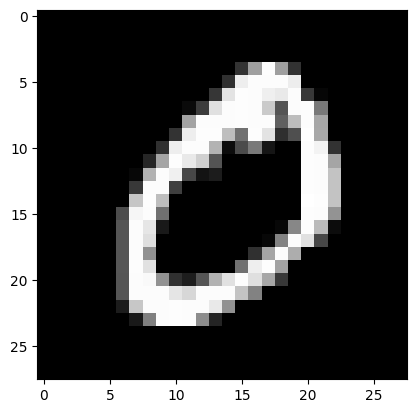

In [4]:
single_image = pixel_values.to_numpy()[1, :].reshape(28, 28)
plt.imshow(single_image, cmap='gray')


In [ ]:
tsne = manifold.TSNE(n_components=2, random_state=42)
transformed_data = tsne.fit_transform(pixel_values[:3000, :])

# Developing Models for Production

## Implementing expewriment tracking using MLflow

In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# create a machine learning model
model = LogisticRegression()

# Start with an MLflow run context
with mlflow.start_run() as run:
    # Log parameteres
    mlflow.log_param("model_algo", "LogisticRegression")
    mlflow.log_param("C", 1.0)

    # Train and test the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_tests, y_pred)

    # Log the model and its metrics 
    mlflow.log_metric("accuracy", accuracy)
    mlflow.sklearn.log_model(model, "model")

## Model downloading with MLFlow

In [ ]:
from mlflow.store.artifact.models_artifact_repo import ModelsArtifactRepository
from mlflow.tracking import MlflowClient

client = MlflowClient()
my_model = client.download_artifacts(
    "5de5f68r6568f64656f85466f48656f", path="model")
print(f"Placed model in: {my_model}")

## Model searching with MLflow

In [ ]:
from pprint import pprint
from mlflow.tracking import MlflowClient

client = MlflowClient()
for rm in client.list_registered_models():
    pprint(dict(rm), indent=4)

## Comparing ML jobs using MLflow

In [ ]:
import mlflow

# Get the runs by ID
run1 = mlflow.get_run(run_id="run_id_1")
run2 = mlflow.get_run(run_id="run_id_2")

#Compare metrics
metric_name = "accuracy"
metric1 = run1.data.metrics[metric_name]
metric2 = run2.data.metrics[metric_name]

print(f"Comparison of {metric_name}")
print(f"Run 1: {metric1}")
print(f"Run 2: {metric2}")

## Hyperparameter tuning

In [ ]:
hp_tuning_run = project.run_function(
    "trainer",
    inputs={"datasets": gen_dataa_run.outputs["dataset"]},
    hyperparams={
        "n_estimators": [100,500,1000],
        "max_depth": [5,15,30]
    },
    selector="max.accuracy"
)

## Auto Logging

In [ ]:
# Using MLflow
import mlflow
from sklearn.ensemble import RandomForestRegressor

mlflow.autolog()

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf.predict(X_test)
print(mlflow.active_run().data.metrics) # logged automatically

In [ ]:
# using sagemaker
# Train model using sagemaker SDK

import sagemaker

ml = sagemaker.estimator.Estimator()

# sagemaker automatically enables Debugger
ml.fit(data)

# View logs
ml.debugger_rules_analysis.load_analytics()

In [ ]:
# Auto-logging in pythoin using MLFLow
import mlflow

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor

mlflow.autolog()

db = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(db.data, db.target)

# Create and train models
rf = RandomForestRegressor(n_estimators=100, max_depth=6, max_features=3)
rf.fit(X_train, y_train)

# USe the model to make predictions on the test dataset
predictions = rf.predict(X_test)
autolog_run = mlflow.last_active_run()

# Github Actions with Azure Machine Learning Studio

In [ ]:
az account show --query id -o tsv

In [ ]:
az ad sp create-for-rbac --sdk-auth --name "github-actions" \
    --role contributor --scopes /subscriptions/$AZURE_SUBSCRIPTION_ID

### Authenticating to azure

In [ ]:
- uses: azure/login@v1
  with:
    creds: ${{ secrets.AZURE_CREDENTIALS }}

In [ ]:
- name: set auto-install of extensions
  run: az config set extension.use_dynamic_instal=yes_without_prompt


In [ ]:
- name: attach workpace
  run: az ml folder attach -w "workspace-name" -g "workspace-group"